In [3]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
import PlaceCellAnalyses.SingleCellSimNMF as scnmf


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [5]:
def run(sess,cells):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,
                                                                              bin_size=10,speed=VRDat['speed']._values)

    effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
    effMorph = (effMorph+.3)/1.6
    msort = np.argsort(effMorph)
    
    
    S_tm_sort = sp.ndimage.filters.gaussian_filter1d(S_trial_mat[msort,:,:],2,axis=1)
    
    for cell in cells:
        f,ax = plt.subplots()
        ax.imshow(S_tm_sort[:,:,cell],cmap='magma')
        tick_inds = np.arange(0,S_trial_mat.shape[0],10)
        morph_s = effMorph[msort]
        tick_labels = ["%.2f" % morph_s[i] for i in tick_inds]
        ax.set_yticks(tick_inds)
        ax.set_yticklabels(tick_labels,fontsize=5)
        ax.set_title("%i" % cell)
        f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')
        
#         reward_pos = trial_info['reward_pos']
#         reward_pos[np.isnan(reward_pos)]= 480.
        
#         b.behavior_raster_foraging(np.squeeze(S_tm_sort[:,:,cell])/np.amax(S_tm_sort[:,:,cell]),
#                                                 centers,effMorph[msort],reward_pos[msort]/480.,smooth=False)

        _s_tm  = np.squeeze(S_tm_sort[:,:,cell])
        _s_tm = _s_tm/np.linalg.norm(_s_tm,ord=2,axis=1)[:,np.newaxis]
        _sim = np.matmul(_s_tm,_s_tm.T)
        f,ax = plt.subplots()
        ax.imshow(_sim,cmap='cividis',vmin=0.3,vmax=1)
        ax.set_title("%i" % cell)
        f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i_sm.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')

        


In [24]:
def pretty_plot(sess,cells):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,
                                                                              bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=1E-10
    effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
    effMorph = (effMorph+.3)/1.6
    msort = np.argsort(effMorph)
    
    
    S_tm_sort = sp.ndimage.filters.gaussian_filter1d(S_trial_mat[msort,:,:],2,axis=1)
    
    f = plt.figure(figsize=[3*(len(cells)+1),9])
    gs = gridspec.GridSpec(3,len(cells)+1)
    gs.update(hspace=.01,wspace=.05)
    for c,cell in enumerate(cells):
        ax_trials = f.add_subplot(gs[:2,c])
        _S_c = S_tm_sort[:,:,cell]
        _S_c/=_S_c.ravel().mean()
        im = ax_trials.imshow(S_tm_sort[:,:,cell],cmap='magma',aspect='auto',vmin=0,vmax=10)
        if c==0:
            tick_inds = np.arange(0,S_trial_mat.shape[0],10)
            morph_s = effMorph[msort]
            tick_labels = ["%.2f" % morph_s[i] for i in tick_inds]
            ax_trials.set_yticks(tick_inds)
            ax_trials.set_yticklabels(tick_labels,fontsize=5)
        else:
            ax_trials.set_yticklabels([])
            ax_trials.set_xticklabels([])
            
        ax_trials.set_title("%i" % cell)
#         f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')
        

        _s_tm  = np.squeeze(S_tm_sort[:,:,cell])
        _s_tm = _s_tm/np.linalg.norm(_s_tm,ord=2,axis=1)[:,np.newaxis]
        _sim = np.matmul(_s_tm,_s_tm.T)
        ax_sm = f.add_subplot(gs[-1,c])
        simm = ax_sm.imshow(_sim,cmap='cividis',vmin=0.3,vmax=1)
#         ax.set_title("%i" % cell)
        ax_sm.set_yticks([])
        ax_sm.set_xticks([])
    cbar_ax = f.add_subplot(gs[:2,c+1])
    f.colorbar(im,cax=cbar_ax)
    scbar_ax = f.add_subplot(gs[-1,c+1])
    f.colorbar(simm,cax=scbar_ax)
        
#         ut = _sim[np.triu_indices_from(_sim)]
#         ff,aax = plt.subplots()
#         aax.imshow(ut[np.newaxis,:],aspect='auto',cmap='cividis',vmin=.3,vmax=1)
#         aax.set_xticks([])
#         aax.set_yticks([])
#         ff.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i_flat.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')
    f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\ExamplePlaceCells", "%s_%s_prettyplot.pdf" % (sess['MouseName'],sess['DateFolder'])),format='pdf')

   

num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
(113863,) (113863, 21)
frame diff 0


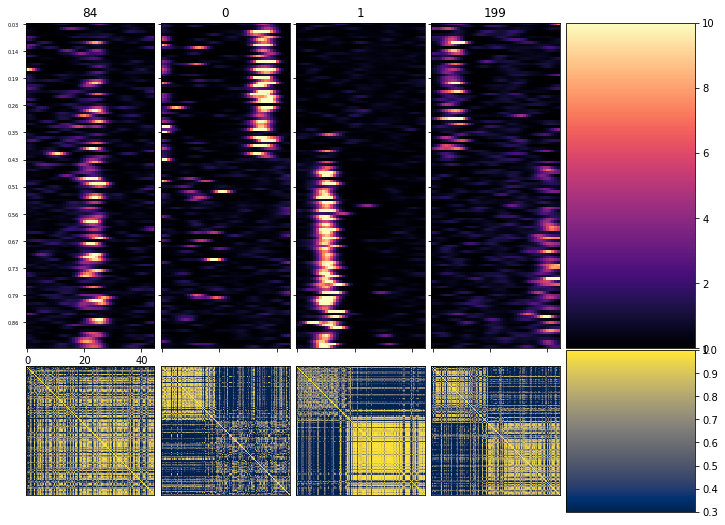

In [21]:
mouse = '4139265.5'
date = '19_02_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
pretty_plot(sess,[84,0,1,199])
# run(sess,[1,0,84,78,329,199,810])

num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
frame diff 0


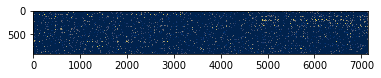

In [48]:
ut,em = scnmf.sim_triu(sess,binned=False,norm=False)
f,ax = plt.subplots()
ax.imshow(ut,cmap='cividis',vmin=.3,vmax=1)
f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_nmfmatrix.pdf" % (sess['MouseName'],sess['DateFolder'])),format='pdf')

num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
(95160,) (95160, 21)
frame diff 0


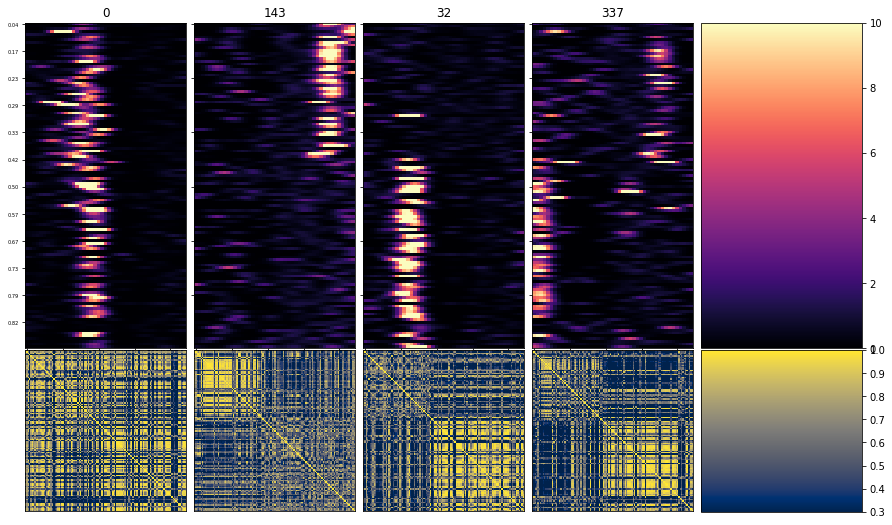

In [25]:
mouse = '4139265.4'
date = '18_02_2019';
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
# run(sess,[0,32,100,143,58,337,120])
pretty_plot(sess,[0,143,32,337])

num aberrant ttls 0.0
35248 (35248,) (35248, 21) 116195


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


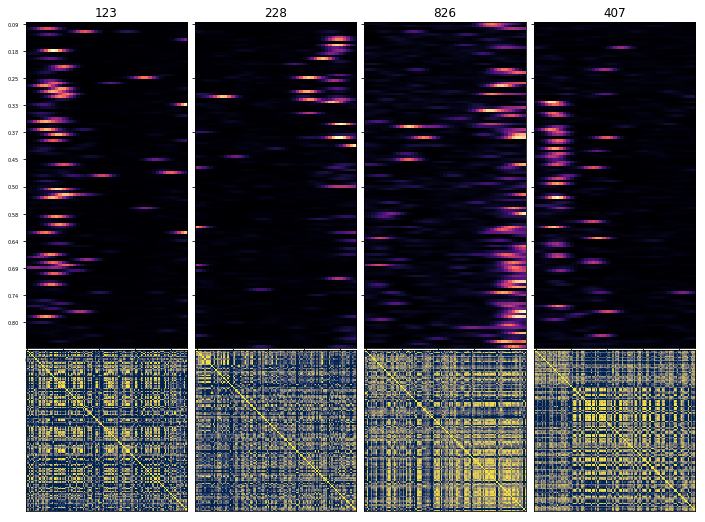

In [40]:
mouse = '4222153.2'
date = '15_04_2019';
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
# run(sess,[123,203,159,826,3,1120,407,228,100,264,303])
pretty_plot(sess,[123,228,826,407])

num aberrant ttls 0.0
36036 (36036,) (36036, 21) 118455


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


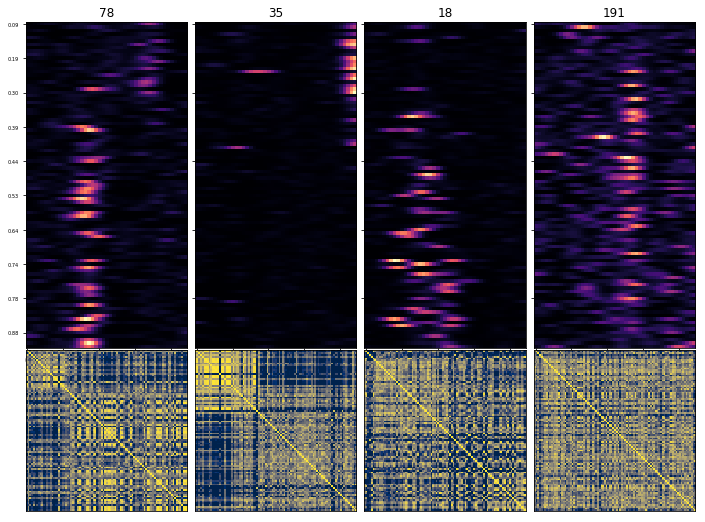

In [41]:
mouse = '4222153.1'
date = '15_04_2019';
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
# run(sess,[28,35,78,18,23,54,106,38,132,191,152])
pretty_plot(sess,[78,35,18,191])

In [6]:
dff = pp.load_session_db()
dff = dff[dff['RewardCount']>30]
dff = dff[dff['Imaging']==1]
dff = dff.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'FreqMorph_Timeout'
dff = dff[dff['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
frame diff 0


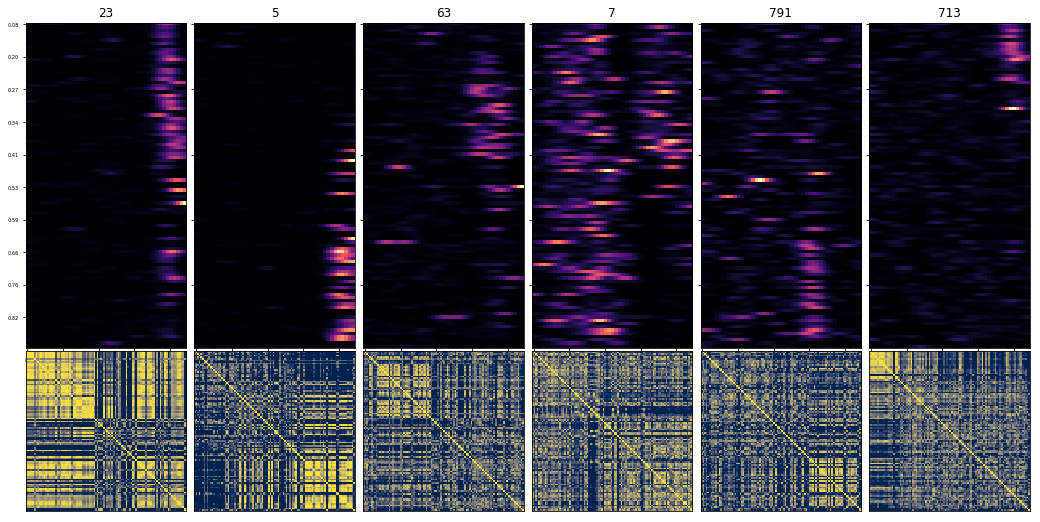

In [13]:
mouse = '4222157.4'
date = '19_06_2019';
dff_mouse = dff[dff['MouseName'].str.match(mouse)]
sess = dff_mouse[dff_mouse['DateFolder'].str.match(date)].iloc[0]

pretty_plot(sess,[23,5,63,7,791,713])

num aberrant ttls 0.0
29030 (29030,) (29030, 21) 83179
(83179,) (83179, 21)
frame diff 0


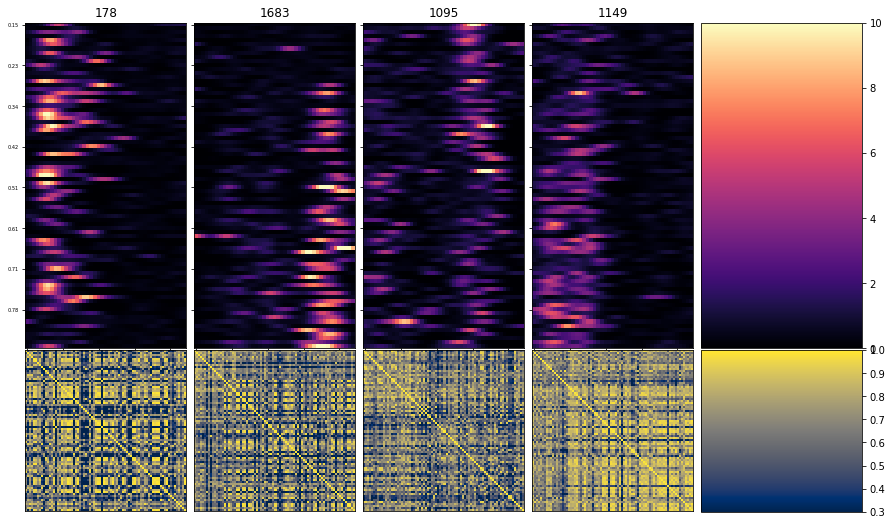

In [27]:
mouse = '4222174.1'
date = '11_06_2019';
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]

pretty_plot(sess,[178,1683,1095,1149])